<div dir="rtl" align="center">
    <h2><strong> HW4: TimeSerie Forcasting with LSTM </strong></h2>
</div>

Sepehr Moniri
981813205

In [44]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns


from torch import nn
from torchvision import transforms
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### **Load Flights Dataset from `Seaborn` library**

In [46]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [47]:
data = flight_data['passengers'].values

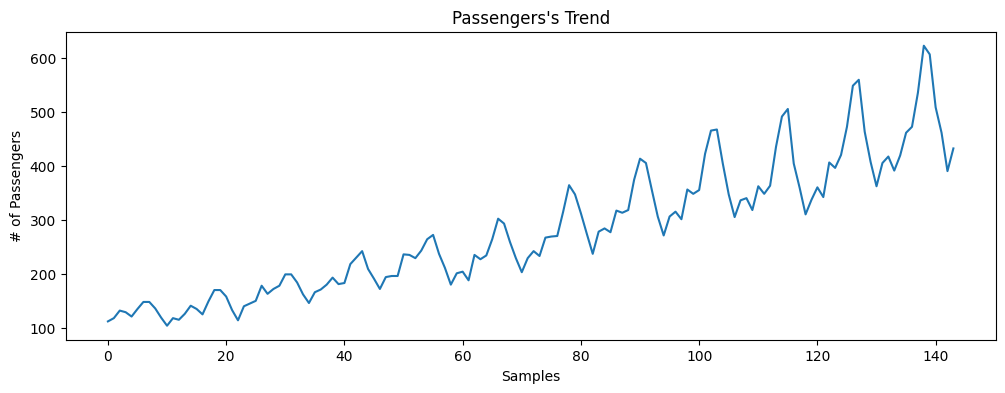

In [48]:
fig, ax = plt.subplots(figsize=(12, 4))

_ = ax.plot(data)

_ = ax.set_title("Passengers's Trend")
_ = ax.set_xlabel("Samples")
_ = ax.set_ylabel("# of Passengers")

### **Normalize Data**

In [49]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data.reshape(-1, 1))

### **Make Sequence Data**

In [50]:
def create_input_sequences(data: np.ndarray, window: int):
    X, labels = [], []
    data_size = len(data)
    for i in range(data_size - window):
        # TODO: COMPLETE THIS CODE
        X.append(data[i:i+window])
        labels.append(data[i+window])

    return np.array(X), np.array(labels)


In [51]:
window_size = 4
X, y = create_input_sequences(data_normalized, window_size)

In [52]:
print(X.shape, y.shape)

(140, 4, 1) (140, 1)


### **Create Custom Dataset Torch**

In [53]:
class SimpleDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray) -> None:
        super(SimpleDataset, self).__init__()
        # TODO: COMPLETE THIS CODE
        self.x = x
        self.y = y

    def __len__(self):
      # TODO: COMPLETE THIS CODE
        return len(self.x)

    def __getitem__(self, index):
      # TODO: COMPLETE THIS CODE
        return self.x[index], self.y[index]

### **Split Train & Test with `test_size=0.2` and `shuffle=False`**

In [54]:
# TODO: COMPLETE THIS CODE

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### **Make Dataset & DataLoader**

In [55]:
trainset = SimpleDataset(x_train, y_train)
testset = SimpleDataset(x_test, y_test)

trainloader = DataLoader(trainset, shuffle=False, batch_size=1)
testloader = DataLoader(testset, shuffle=False, batch_size=1)

### **Make RNN model base LSTM**

In [56]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(CustomLSTM, self).__init__()
        # TODO: COMPLETE THIS CODE
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        # TODO: COMPLETE THIS CODE
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

### **Define Model, Criterion and Optimizer(SGD with lr=0.001)**

In [57]:
model = CustomLSTM(input_size=4, hidden_layer_size=128, output_size=1).to(device)

# TODO: COMPLETE THIS CODE

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

### **Training CustomLSTM**

In [58]:
EPOCHS = 500

model.train()
for i in range(EPOCHS):
    for seq, labels in trainloader:
        seq, labels = seq.to(device).float(), labels.to(device).float()
        optimizer.zero_grad()
        model.hidden_cell = (
            torch.zeros(1, 1, model.hidden_layer_size).to(device),
            torch.zeros(1, 1, model.hidden_layer_size).to(device)
        )

        # TODO: COMPLETE THIS CODE
        y_pred = model(seq)

        single_loss = criterion(y_pred, labels)
        single_loss.backward()
        optimizer.step()


    if (i + 1) % 50 == 0:
        print(f'epoch: {i + 1}/{EPOCHS}\tloss: {single_loss.item():10.8f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 50/500	loss: 0.68971539
epoch: 100/500	loss: 0.42775357
epoch: 150/500	loss: 0.23946531
epoch: 200/500	loss: 0.15016960
epoch: 250/500	loss: 0.11325680
epoch: 300/500	loss: 0.09659410
epoch: 350/500	loss: 0.08727871
epoch: 400/500	loss: 0.08071320
epoch: 450/500	loss: 0.07528471
epoch: 500/500	loss: 0.07042279


### **Evaluating CustomLSTM**

In [59]:
model.eval()
predicts = []

for seq, labels in testloader:
    seq = seq.to(device).float()

    # TODO: COMPLETE THIS CODE
    with torch.no_grad():
        model.hidden_cell = (
            torch.zeros(1, 1, model.hidden_layer_size).to(device),
            torch.zeros(1, 1, model.hidden_layer_size).to(device)
        )
        predicts.append(model(seq).item())

predicts = scaler.inverse_transform(np.array(predicts).reshape(-1, 1))
print(predicts)


[[469.02615207]
 [451.04965773]
 [420.04224411]
 [372.94342763]
 [350.5140667 ]
 [351.14968298]
 [347.19793353]
 [377.99588493]
 [388.54626315]
 [405.49058971]
 [438.86537519]
 [483.25756112]
 [515.00998574]
 [499.87378651]
 [468.93117222]
 [423.27143559]
 [407.89814565]
 [407.043134  ]
 [400.86319908]
 [414.36948848]
 [434.74436882]
 [450.13464013]
 [487.99548498]
 [540.17911404]
 [562.40811998]
 [544.92305857]
 [515.39330143]
 [460.24816892]]


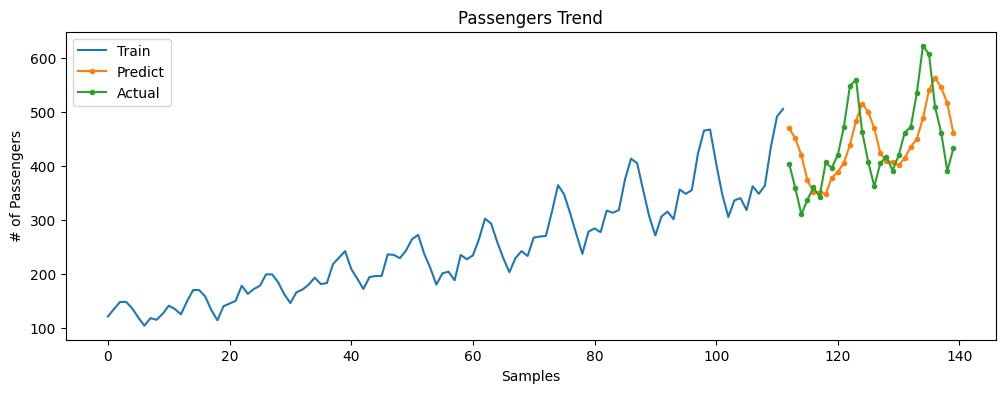

In [62]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(range(len(y_train)), scaler.inverse_transform(y_train.reshape(-1, 1)), label='Train')

predicted_indices = range(len(y_train), len(y_train) + len(predicts))
actual_indices = range(len(y_train), len(y_train) + len(y_test))

ax.plot(predicted_indices, predicts, marker='.', label='Predict')
ax.plot(actual_indices, scaler.inverse_transform(y_test.reshape(-1, 1)), marker='.', label='Actual')

ax.set_title("Passengers Trend")
ax.set_xlabel("Samples")
ax.set_ylabel("# of Passengers")
ax.legend()

plt.show()